In [1]:
import pandas as pd
import numpy as np
import pickle

import re

import csv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

import geopandas as gpd
import shapely.geometry as sg
from shapely.geometry import MultiPolygon, Polygon


# Defining functions

In [2]:
# defining dissimilarity function
def dissimilarity(df):
    dissimilarity_results = {}
    for col in df.columns:
        col_numerator = []
        for i in range(df.shape[0]):
            col_numerator.append((df.iloc[i,:].sum() / df.sum().sum()) *
                                 np.abs((df.loc[i, col] / df.iloc[i,:].sum() - (df[col].sum() / df.sum().sum()))))
        col_numerator = sum(col_numerator)
        col_denominator = 2 * (df[col].sum() / df.sum().sum()) * (1 - (df[col].sum() / df.sum().sum()))
        dissimilarity_results[col] = round(col_numerator / col_denominator, 3)

        # print(f'dissimilarity {col} = {col_numerator/col_denominator}')
    return dissimilarity_results              
        

In [3]:
#| include: false

# defining simpson function

def simpson(df):
    simpson_series = []
    for i in range(df.shape[0]):
        area_ethnic_fraction_2 = []
        for col in df.columns:
            if col != 'other':
                area_ethnic_fraction_2.append((df.loc[i,col]/(df.iloc[i,:].sum()))**2)
        sum_area_ethnic_fraction_2 = sum(area_ethnic_fraction_2)
        simpson_series.append(sum_area_ethnic_fraction_2)
        
    simpson_series = pd.Series(simpson_series)
    simpson_index = 0
    for i in range(df.shape[0]):
        simpson_index += (simpson_series.iloc[i] * df.iloc[i, :].sum() / df.sum().sum())
    
    area_simpson = []
    for col in df.columns:
        if col != 'other':
            area_simpson.append((df[col].sum()/df.sum().sum())**2)
    area_simpson_index = sum(area_simpson)
    simpson_index = round(simpson_index, 3)
    area_simpson_index = round(area_simpson_index, 3)
    return [simpson_index, area_simpson_index]

In [4]:
# defining moran I function

def moran(df,border):
    positive_weights = []
    for key in border.keys():
        positive_weights.append(len(border[key]))
       
    fraction = {}
    for col in df.columns:
        # df[col] = pd.to_numeric(df[col], errors='coerce')
        fraction[col] = []
        for i in df.index:
            fraction[col].append(df.loc[i, col] / df.loc[i, :].sum())
    
    col_moran = {} 
    for col in df.columns:
        col_moran_list = []
        for i in df.index:
            morani = []
            for common in border[i]:    
                morani.append(((df.loc[i, col] / df.loc[i, :].sum()) - np.mean(fraction[col])) * ((df.loc[common, col] / df.loc[common, :].sum()) - np.mean(fraction[col])))
            row_moran = sum(morani)
            col_moran_list.append(row_moran)
        col_moran[col] = col_moran_list
    moran_results= {}
    for col in df.columns:
        moran_numerator = sum(col_moran[col])*df.shape[0]
        moran_denominator = sum((fraction[col] - np.mean(fraction[col]))**2)*sum(positive_weights)
        # moran_index = moran_numerator/moran_denominator
        moran_results[col] = round(moran_numerator/moran_denominator, 3)
    return moran_results


# Preprocessing

In [5]:
data_2021 = pd.read_csv('Census2021\\census2021.csv', encoding= 'latin1', delimiter= ',')

In [6]:
data_2021.head()

,Output Areas Code,Output Areas,Ethnic group (20 categories) Code,Ethnic group (20 categories),Observation
0,E00000001,E00000001,-8,Does not apply,0
1,E00000001,E00000001,1,"Asian, Asian British or Asian Welsh: Bangladeshi",0
2,E00000001,E00000001,2,"Asian, Asian British or Asian Welsh: Chinese",4
3,E00000001,E00000001,3,"Asian, Asian British or Asian Welsh: Indian",0
4,E00000001,E00000001,4,"Asian, Asian British or Asian Welsh: Pakistani",1


In [7]:
data_2021.shape

(3777600, 5)

In [8]:
data_2021.drop(columns = ['Output Areas Code','Ethnic group (20 categories) Code'], inplace = True)

In [9]:
data_2021['Ethnic group (20 categories)'].unique()

array(['Does not apply',
       'Asian, Asian British or Asian Welsh: Bangladeshi',
       'Asian, Asian British or Asian Welsh: Chinese',
       'Asian, Asian British or Asian Welsh: Indian',
       'Asian, Asian British or Asian Welsh: Pakistani',
       'Asian, Asian British or Asian Welsh: Other Asian',
       'Black, Black British, Black Welsh, Caribbean or African: African',
       'Black, Black British, Black Welsh, Caribbean or African: Caribbean',
       'Black, Black British, Black Welsh, Caribbean or African: Other Black',
       'Mixed or Multiple ethnic groups: White and Asian',
       'Mixed or Multiple ethnic groups: White and Black African',
       'Mixed or Multiple ethnic groups: White and Black Caribbean',
       'Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups',
       'White: English, Welsh, Scottish, Northern Irish or British',
       'White: Irish', 'White: Gypsy or Irish Traveller', 'White: Roma',
       'White: Other White', 'Other ethnic

In [10]:
data_2021['Ethnic group (20 categories)'] = data_2021['Ethnic group (20 categories)'].apply( lambda x: 'Other: Other' if 'Does not apply' in x else x)

In [11]:
data_2021['ethnicity'] = data_2021['Ethnic group (20 categories)'].apply( lambda x: x.split(':')[0])
data_2021['sub_ethnicity'] = data_2021['Ethnic group (20 categories)'].apply( lambda x: x.split(':')[1])
data_2021.drop('Ethnic group (20 categories)', axis= 1, inplace= True)
data_2021.head()

,Output Areas,Observation,ethnicity,sub_ethnicity
0,E00000001,0,Other,Other
1,E00000001,0,"Asian, Asian British or Asian Welsh",Bangladeshi
2,E00000001,4,"Asian, Asian British or Asian Welsh",Chinese
3,E00000001,0,"Asian, Asian British or Asian Welsh",Indian
4,E00000001,1,"Asian, Asian British or Asian Welsh",Pakistani


In [12]:
data_2021['ethnicity'].unique()

array(['Other', 'Asian, Asian British or Asian Welsh',
       'Black, Black British, Black Welsh, Caribbean or African',
       'Mixed or Multiple ethnic groups', 'White', 'Other ethnic group'],
      dtype=object)

In [13]:
data_2021['sub_ethnicity']= data_2021['sub_ethnicity'].apply(str.lstrip)
data_2021['sub_ethnicity'].unique()

array(['Other', 'Bangladeshi', 'Chinese', 'Indian', 'Pakistani',
       'Other Asian', 'African', 'Caribbean', 'Other Black',
       'White and Asian', 'White and Black African',
       'White and Black Caribbean',
       'Other Mixed or Multiple ethnic groups',
       'English, Welsh, Scottish, Northern Irish or British', 'Irish',
       'Gypsy or Irish Traveller', 'Roma', 'Other White', 'Arab',
       'Any other ethnic group'], dtype=object)

In [14]:
# Deviding the Ethnicity in 4 groups
data_2021['ethnicity'] = data_2021['ethnicity'].apply(lambda x: 'white' if 'White' in x else
                                                                'asian' if 'Asian' in x else 
                                                                'black' if 'Black' in x else 'other')
data_2021.head()

,Output Areas,Observation,ethnicity,sub_ethnicity
0,E00000001,0,other,Other
1,E00000001,0,asian,Bangladeshi
2,E00000001,4,asian,Chinese
3,E00000001,0,asian,Indian
4,E00000001,1,asian,Pakistani


In [15]:
lookup_2021 = pd.read_csv('Census2021\\lookup2021.csv', encoding = 'latin1', low_memory=False)
lookup_2021.rename(columns={'oa21cd':'OA21CD', 'lsoa21cd':'LSOA21CD', 'lsoa21nm': 'LSOA21NM', 'msoa21cd': 'MSOA21CD',
                            'msoa21nm': 'MSOA21NM' , 'lad22cd': 'LAD21CD' ,'lad22nm': 'LAD21NM' ,'lad22nmw': 'LAD21NMW'}, inplace= True)

In [16]:
lookup_2021.head()

,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD21CD,LAD21NM,LAD21NMW
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,NaN


In [17]:
merged_2021 = pd.merge(data_2021, lookup_2021, left_on= 'Output Areas', right_on= 'OA21CD', how= 'left')
merged_2021.head(2)

,Output Areas,Observation,ethnicity,sub_ethnicity,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LAD21CD,LAD21NM,LAD21NMW
0,E00000001,0,other,Other,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN
1,E00000001,0,asian,Bangladeshi,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN


In [18]:
column_order = ['OA21CD', 'LSOA21CD', 'MSOA21CD', 'LAD21CD', 
                'LSOA21NM','MSOA21NM', 'LAD21NM', 'ethnicity', 'sub_ethnicity', 'Observation']
merged_2021 = merged_2021[column_order]
merged_2021.head(5)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,ethnicity,sub_ethnicity,Observation
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,other,Other,0
1,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Bangladeshi,0
2,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Chinese,4
3,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Indian,0
4,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Pakistani,1


In [19]:
len(merged_2021['OA21CD'].unique())

188880

In [20]:
len(merged_2021['LSOA21CD'].unique())

35672

In [21]:
len(merged_2021['MSOA21CD'].unique())

7264

In [22]:
len(merged_2021['LAD21CD'].unique())

331

In [23]:
merged_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,ethnicity,sub_ethnicity,Observation
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,other,Other,0
1,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Bangladeshi,0
2,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,Chinese,4


# Ethnicity Dataset

In [24]:
ethnicity_2021 = merged_2021.groupby(['OA21CD','LSOA21CD', 'MSOA21CD', 'LAD21CD', 'LSOA21NM', 'MSOA21NM', 'LAD21NM',
                                      'ethnicity'])['Observation'].sum().reset_index()
ethnicity_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,ethnicity,Observation
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,asian,5
1,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,black,3
2,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,other,13


In [25]:
ethnicity_2021 = ethnicity_2021.pivot(index = ['OA21CD','LSOA21CD', 'MSOA21CD', 'LAD21CD', 'LSOA21NM', 'MSOA21NM', 'LAD21NM'], 
                                      columns = 'ethnicity', values = 'Observation').reset_index().rename_axis(None, axis=1)

ethnicity_2021['total_pop']= ethnicity_2021['white']+ethnicity_2021['asian']+ethnicity_2021['black']+ethnicity_2021['other']

ethnicity_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,asian,black,other,white,total_pop
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,5,3,13,155,176
1,E00000003,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,24,5,17,209,255
2,E00000005,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,13,0,14,85,112


In [26]:
ethnicity_2021[['asian', 'black', 'other','white']].sum(axis= 0).sum()

59598449

In [27]:
ethnicity_2021.to_csv('preprocessed files/2021/ethnicity_2021.csv', index= False)

# Sub-Ethnicity Dataset

In [28]:
sub_ethnicity_2021 = merged_2021.groupby(['OA21CD','LSOA21CD', 'MSOA21CD', 'LAD21CD', 'LSOA21NM', 'MSOA21NM', 'LAD21NM',
                                          'sub_ethnicity'])['Observation'].sum().reset_index()
sub_ethnicity_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,sub_ethnicity,Observation
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,African,0
1,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,Any other ethnic group,7
2,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,Arab,0


In [29]:
sub_ethnicity_2021 = sub_ethnicity_2021.pivot(index = ['OA21CD','LSOA21CD', 'MSOA21CD', 'LAD21CD', 'LSOA21NM', 'MSOA21NM', 'LAD21NM'],
                                              columns = 'sub_ethnicity', values = 'Observation').reset_index().rename_axis(None, axis=1)
sub_ethnicity_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,LSOA21NM,MSOA21NM,LAD21NM,African,Any other ethnic group,Arab,...,Other,Other Asian,Other Black,Other Mixed or Multiple ethnic groups,Other White,Pakistani,Roma,White and Asian,White and Black African,White and Black Caribbean
0,E00000001,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,0,7,0,...,0,0,0,1,39,1,4,5,0,0
1,E00000003,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,5,3,1,...,0,7,0,7,35,0,0,6,0,0
2,E00000005,E01000001,E02000001,E09000001,City of London 001A,City of London 001,City of London,0,7,1,...,0,5,0,2,20,0,0,2,2,0


In [30]:
sub_ethnicity_2021.to_csv('preprocessed files/2021/sub_ethnicity_2021.csv', index= False)

# Shape Files

In [31]:
shape_2021 = gpd.read_file('Census2021\\shape_2021\\OA_2021_EW_BGC_V2.shp')
# shape_2021.info()

In [32]:
shape_2021 = shape_2021.rename(columns={'geometry': 'OA_geometry'})
shape_2021.head(3)

,OA21CD,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,OA_geometry
0,E00000001,E01000001,City of London 001A,None,532250,181864,51.5202,-0.09523,3a44dd3d-5082-4a09-9b9c-3a5fadc811ed,"POLYGON ((532303.492 181814.110, 532213.378 18..."
1,E00000003,E01000001,City of London 001A,None,532171,181819,51.5198,-0.09638,f1216dc8-14d1-4857-9230-cab0641758fb,"POLYGON ((532213.378 181846.192, 532190.539 18..."
2,E00000005,E01000001,City of London 001A,None,532166,181722,51.5190,-0.09649,44d6f70f-549c-4288-9b6d-de2adbf02582,"POLYGON ((532180.131 181763.020, 532219.161 18..."


In [33]:
shape_2021 = shape_2021.merge(ethnicity_2021[['OA21CD', 'LSOA21CD', 'MSOA21CD', 'LAD21CD']], on = 'OA21CD', how= 'left')
shape_column_order = ['OA21CD', 'LSOA21CD_x', 'MSOA21CD', 'LAD21CD', 'GlobalID', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'OA_geometry']
shape_2021 = shape_2021[shape_column_order]
shape_2021.rename(columns= {'LSOA21CD_x': 'LSOA21CD'}, inplace= True)
shape_2021 = gpd.GeoDataFrame(shape_2021, geometry='OA_geometry')
shape_2021.head(3)

,OA21CD,LSOA21CD,MSOA21CD,LAD21CD,GlobalID,BNG_E,BNG_N,LAT,LONG,OA_geometry
0,E00000001,E01000001,E02000001,E09000001,3a44dd3d-5082-4a09-9b9c-3a5fadc811ed,532250,181864,51.5202,-0.09523,"POLYGON ((532303.492 181814.110, 532213.378 18..."
1,E00000003,E01000001,E02000001,E09000001,f1216dc8-14d1-4857-9230-cab0641758fb,532171,181819,51.5198,-0.09638,"POLYGON ((532213.378 181846.192, 532190.539 18..."
2,E00000005,E01000001,E02000001,E09000001,44d6f70f-549c-4288-9b6d-de2adbf02582,532166,181722,51.5190,-0.09649,"POLYGON ((532180.131 181763.020, 532219.161 18..."


In [34]:
# Saving OA_2021 into a shape file
shape_2021.to_file('preprocessed files/2021/OA_2021.shp')

C:\Users\niloo\AppData\Local\Temp\ipykernel_23768\1375500454.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shape_2021.to_file('preprocessed files/2021/OA_2021.shp')


<Axes: >

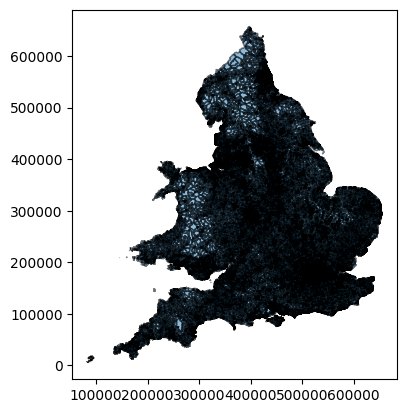

In [35]:
OA_2021 = gpd.read_file('preprocessed files/2021/OA_2021.shp').set_geometry('geometry')
OA_2021.plot(alpha=0.5, edgecolor='k')

In [36]:
# creating new culumns in shape file for LSOA geometry
lsoa_geom_2021 = shape_2021.groupby('LSOA21CD')['OA_geometry'].agg(lambda x: x.unary_union)
shape_2021['LSOA_geometry'] = shape_2021['LSOA21CD'].map(lsoa_geom_2021)

In [37]:
# Saving LSOA_2021 into a shape file
LSOA_2021 = shape_2021.groupby('LSOA21CD').agg({'LSOA_geometry': 'first'}).reset_index()
LSOA_2021 = LSOA_2021.merge(ethnicity_2021.groupby('LSOA21CD')[['asian', 'black', 'other', 'white']].sum().reset_index(), on='LSOA21CD' ,how= 'left')

LSOA_2021['total'] = LSOA_2021['white'] + LSOA_2021['asian']+ LSOA_2021['black']+ LSOA_2021['other']

for col in LSOA_2021[['asian', 'black', 'other', 'white']]:
    new_name = col + '_fraction'
    LSOA_2021[new_name] = round(LSOA_2021[col]/LSOA_2021['total'], 3)

LSOA_2021['year'] = 2021
LSOA_2021.rename(columns={'LSOA21CD':'LSOACD'}, inplace = True)
column_order = ['year', 'LSOACD', 'white', 'asian', 'black', 'other',
                'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'total', 'LSOA_geometry']
LSOA_2021 = LSOA_2021[column_order]

LSOA_2021 = gpd.GeoDataFrame(LSOA_2021, geometry='LSOA_geometry')
LSOA_2021.to_file('preprocessed files/2021/LSOA_2021.shp', driver='ESRI Shapefile')

C:\Users\niloo\AppData\Local\Temp\ipykernel_23768\760856440.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  LSOA_2021.to_file('preprocessed files/2021/LSOA_2021.shp', driver='ESRI Shapefile')


<Axes: >

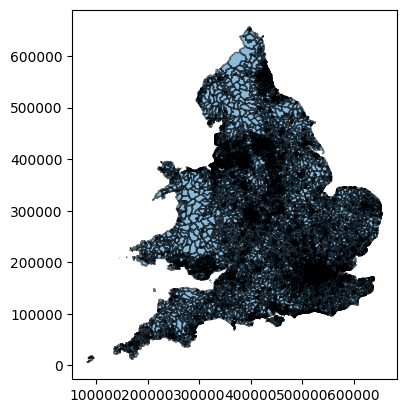

In [38]:
LSOA_2021 = gpd.read_file('preprocessed files/2021/LSOA_2021.shp').set_geometry('geometry')
LSOA_2021.plot(alpha=0.5, edgecolor='k')

In [39]:
# creating new culumns in shape file for MSOA geometry
msoa_geom_2021 = shape_2021.groupby('MSOA21CD')['LSOA_geometry'].agg(lambda x: x.unary_union)
shape_2021['MSOA_geometry'] = shape_2021['MSOA21CD'].map(msoa_geom_2021)

In [40]:
# Saving MSOA_2021 into a shape file
MSOA_2021 = shape_2021.groupby('MSOA21CD').agg({'MSOA_geometry': 'first'}).reset_index()
MSOA_2021 = MSOA_2021.merge(ethnicity_2021.groupby('MSOA21CD')[['asian', 'black', 'other', 'white']].sum().reset_index(), on='MSOA21CD' ,how= 'left')

MSOA_2021['total'] = MSOA_2021['white'] + MSOA_2021['asian']+ MSOA_2021['black']+ MSOA_2021['other']

for col in MSOA_2021[['asian', 'black', 'other', 'white']]:
    new_name = col + '_fraction'
    MSOA_2021[new_name] = round(MSOA_2021[col]/MSOA_2021['total'], 3)

MSOA_2021['year'] = 2021
MSOA_2021.rename(columns={'MSOA21CD':'MSOACD'}, inplace = True)
column_order = ['year', 'MSOACD', 'white', 'asian', 'black', 'other',
                'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'total', 'MSOA_geometry']
MSOA_2021 = MSOA_2021[column_order]

MSOA_2021 = gpd.GeoDataFrame(MSOA_2021, geometry='MSOA_geometry')
MSOA_2021.to_file('preprocessed files/2021/MSOA_2021.shp', driver='ESRI Shapefile')

C:\Users\niloo\AppData\Local\Temp\ipykernel_23768\3491027165.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  MSOA_2021.to_file('preprocessed files/2021/MSOA_2021.shp', driver='ESRI Shapefile')


<Axes: >

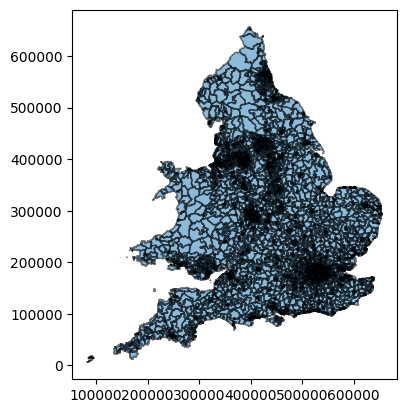

In [41]:
MSOA_2021 = gpd.read_file('preprocessed files/2021/MSOA_2021.shp').set_geometry('geometry')
MSOA_2021.plot(alpha=0.5, edgecolor='k')

In [42]:
# creating new culumns in shape file for LAD geometry
lad_geom_2021 = shape_2021.groupby('LAD21CD')['MSOA_geometry'].agg(lambda x: x.unary_union)
shape_2021['LAD_geometry'] = shape_2021['LAD21CD'].map(lad_geom_2021)


In [43]:
# In order t have better and clearer borders of LAD, I took border info from another files and mixed it with LAD borders of 2021
# For the LADs that geometry was unavailable in new_borders, I took LAD geopmetry from year 2011
new_borders = gpd.read_file('May_2020_Boundaries/LAD_May_2020_Boundaries_UK_BFE_2022_4839426458879395509.geojson')

In [44]:
# Saving LAD_2021 into a shape file
LAD_2021 = shape_2021.groupby('LAD21CD').agg({'LAD_geometry': 'first'}).reset_index()
LAD_2021 = LAD_2021.merge(ethnicity_2021.groupby(['LAD21CD', 'LAD21NM'])[['asian', 'black', 'other', 'white']].sum().reset_index(), on='LAD21CD' ,how= 'left')
LAD_2021['LAD_pop'] = LAD_2021['white'] + LAD_2021['asian']+ LAD_2021['black']+ LAD_2021['other']

for col in LAD_2021[['asian', 'black', 'other', 'white']]:
    new_name = col + '_fraction'
    LAD_2021[new_name] = round(LAD_2021[col]/LAD_2021['LAD_pop'], 3)

LAD_2021['year'] = 2021
LAD_2021.rename(columns={'LAD21CD':'LADCD', 'LAD21NM':'LADNM'}, inplace = True)
column_order = ['year','LADCD', 'LADNM', 'white', 'asian', 'black', 'other',
                'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'LAD_pop', 'LAD_geometry']
LAD_2021 = LAD_2021[column_order]

LAD_2021 =  pd.merge(LAD_2021, new_borders[['lad20nm', 'geometry']], left_on= 'LADNM',right_on='lad20nm', how= 'left')
LAD_2021['geometry']= LAD_2021['geometry'].fillna(LAD_2021['LAD_geometry'])
LAD_2021.drop(columns=['LAD_geometry','lad20nm'], axis= 1, inplace= True)
LAD_2021.rename(columns={'geometry':'LAD_geometry'}, inplace= True)

LAD_2021 = gpd.GeoDataFrame(LAD_2021, geometry='LAD_geometry')
LAD_2021.to_file('preprocessed files/2021/LAD_2021.shp', driver='ESRI Shapefile')


C:\Users\niloo\AppData\Local\Temp\ipykernel_23768\4126414879.py:22: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  LAD_2021.to_file('preprocessed files/2021/LAD_2021.shp', driver='ESRI Shapefile')


<Axes: >

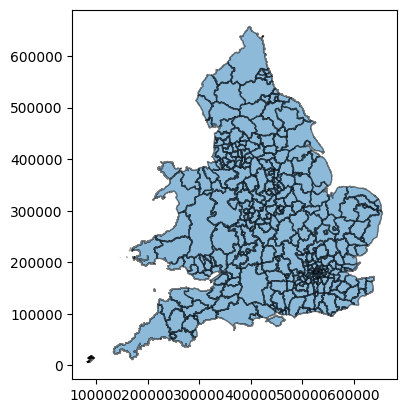

In [45]:
LAD_2021 = gpd.read_file('preprocessed files/2021/LAD_2021.shp').set_geometry('geometry')
LAD_2021.plot(alpha=0.5, edgecolor='k')

# Indexes

## Simpson

In [46]:
OA_simp_2021 = simpson(ethnicity_2021[['white','asian','black','other']])
LSOA_simp_2021 = simpson(ethnicity_2021.groupby(['LSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
MSOA_simp_2021 = simpson(ethnicity_2021.groupby(['MSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
LAD_simp_2021 = simpson(ethnicity_2021.groupby(['LAD21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])

country_dic_sim_2021 = {'OA':OA_simp_2021[0], 'LSOA':LSOA_simp_2021[0],
                        'MSOA':MSOA_simp_2021[0], 'LAD':LAD_simp_2021[0], 'country':LAD_simp_2021[1]}

flat_dict = [{'year': 2021, 'total_population': ethnicity_2021['total_pop'].sum(),
              'white_frac': round(ethnicity_2021['white'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'asian_frac': round(ethnicity_2021['asian'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'black_frac': round(ethnicity_2021['black'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'other_frac': round(ethnicity_2021['other'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'OA':OA_simp_2021[0], 'LSOA':LSOA_simp_2021[0],'MSOA':MSOA_simp_2021[0], 'LAD':LAD_simp_2021[0], 'country':LAD_simp_2021[1]}]

country_simpson_2021 = pd.DataFrame(flat_dict)
country_simpson_2021.to_csv('preprocessed files/2021/country_simpson_2021.csv', index= False)
country_simpson_2021

,year,total_population,white_frac,asian_frac,black_frac,other_frac,OA,LSOA,MSOA,LAD,country
0,2021,59598449,0.817,0.093,0.04,0.05,0.753,0.747,0.743,0.721,0.678


In [47]:
#| include: false
# Creating LAD level simpson index dataset for year 2021.
# Calculating OA, LSOA and MSOA level simpson index inside each LAD
LAD_list_2021= ethnicity_2021['LAD21CD'].unique()
LAD_dic = {}
for LAD in LAD_list_2021:
    df = ethnicity_2021[ethnicity_2021['LAD21CD'] == LAD].reset_index(drop= True)
    OA_LADsimp_2021 = simpson(df[['white','asian','black','other']])
    LSOA_LADsimp_2021 = simpson(df.groupby(['LSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
    MSOA_LADsimp_2021 = simpson(df.groupby(['MSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
    LAD_dic[LAD] = {'OA':OA_LADsimp_2021, 'LSOA':LSOA_LADsimp_2021,'MSOA':MSOA_LADsimp_2021}

flat_dict = [{'year': 2021, 'LADCD': key, 
              'OA': value['OA'][0], 'LSOA': value['LSOA'][0],
              'MSOA': value['MSOA'][0], 'LAD': value['MSOA'][1]} for key, value in LAD_dic.items()]

LAD_simpson_2021 = pd.DataFrame(flat_dict)

LAD_simpson_2021 = LAD_simpson_2021.merge(
                         LAD_2021.groupby(['LADCD','LADNM'])[['LAD_pop','white_frac','asian_frac','black_frac','other_frac']].sum().reset_index(),
                         on= 'LADCD', how='left')

LAD_simpson_2021.rename(columns = {'LAD_pop': 'LAD_population'} ,inplace= True)

column_order = ['year', 'LADNM', 'LADCD', 'LAD_population',
                'white_frac', 'asian_frac', 'black_frac', 'other_frac', 
                'OA', 'LSOA', 'MSOA', 'LAD']

LAD_simpson_2021 = LAD_simpson_2021[column_order]
LAD_simpson_2021.to_csv('preprocessed files/2021/LAD_simpson_2021.csv', index= False)
LAD_simpson_2021.head()

,year,LADNM,LADCD,LAD_population,white_frac,asian_frac,black_frac,other_frac,OA,LSOA,MSOA,LAD
0,2021,City of London,E09000001,8584,0.695,0.168,0.027,0.111,0.544,0.533,0.512,0.512
1,2021,Barking and Dagenham,E09000002,218867,0.449,0.258,0.214,0.079,0.361,0.349,0.342,0.314
2,2021,Barnet,E09000003,389403,0.577,0.193,0.079,0.152,0.407,0.398,0.391,0.376
3,2021,Bexley,E09000004,246516,0.719,0.099,0.122,0.060,0.584,0.578,0.573,0.541
4,2021,Brent,E09000005,339885,0.346,0.328,0.175,0.151,0.340,0.325,0.315,0.258


## Borders

In [45]:
LAD_borders_2021 = {}

for idx, row in shape_2021.groupby('LAD21CD').agg({'LAD_geometry': 'first'}).iterrows():
    borders = []
    for idx2, row2 in shape_2021.groupby('LAD21CD').agg({'LAD_geometry': 'first'}).iterrows():
        if idx != idx2:
            if row.LAD_geometry.intersects(row2.LAD_geometry):
                borders.append(idx2)
    LAD_borders_2021[idx] = borders

In [46]:
with open('preprocessed files/2021/LAD_borders_2021.pkl', 'wb') as f:
    pickle.dump(LAD_borders_2021, f)

In [47]:
MSOA_borders_2021 = {}
for lad_code in shape_2021['LAD21CD'].unique():
    df_lad = shape_2021[shape_2021['LAD21CD'] == lad_code]
    MSOA_borders_2021[lad_code] = {}
    df_msoa =df_lad.groupby('MSOA21CD').agg({'MSOA_geometry': 'first'})
    for idx, row in df_msoa.iterrows():
        borders = []
        for idx2, row2 in df_msoa.iterrows():
            if idx != idx2:
                if row['MSOA_geometry'].intersects(row2['MSOA_geometry']):
                    borders.append(idx2)
        MSOA_borders_2021[lad_code][idx] = borders


In [48]:
with open('preprocessed files/2021/MSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(MSOA_borders_2021, f)

In [49]:
LSOA_borders_2021 = {}
for lad_code in shape_2021['LAD21CD'].unique():
    df_lad = shape_2021[shape_2021['LAD21CD'] == lad_code]
    LSOA_borders_2021[lad_code] = {}
    df_lsoa =df_lad.groupby('LSOA21CD').agg({'LSOA_geometry': 'first'})
    for idx, row in df_lsoa.iterrows():
        borders = []
        for idx2, row2 in df_lsoa.iterrows():
            if idx != idx2:
                if row['LSOA_geometry'].intersects(row2['LSOA_geometry']):
                    borders.append(idx2)
        LSOA_borders_2021[lad_code][idx] = borders


In [50]:
with open('preprocessed files/2021/LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(LSOA_borders_2021, f)

In [51]:
OA_borders_2021 = {}
for lad_code in shape_2021['LAD21CD'].unique():
    df_lad = shape_2021[shape_2021['LAD21CD'] == lad_code]
    OA_borders_2021[lad_code] = {}
    df_oa = df_lad.set_index('OA21CD')
    for idx, row in df_oa.iterrows():
        borders = []
        for idx2, row2 in df_oa.iterrows():
            if idx != idx2:
                if row['OA_geometry'].intersects(row2['OA_geometry']):
                    borders.append(idx2)
        OA_borders_2021[lad_code][idx] = borders


In [52]:
with open('preprocessed files/2021/OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(OA_borders_2021, f)

## Dissimilarity

In [53]:
# Creating country level dissimilarity index dataset for year 2021.
# Calculating OA, LSOA, MSOA and LAD level dissimilarity index inside england

OA_diss_2021 = dissimilarity(ethnicity_2021[['white','asian','black','other']])
LSOA_diss_2021 = dissimilarity(ethnicity_2021.groupby(['LSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
MSOA_diss_2021 = dissimilarity(ethnicity_2021.groupby(['MSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
LAD_diss_2021 = dissimilarity(ethnicity_2021.groupby(['LAD21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
country_dic_diss_2021 = {'OA_level': OA_diss_2021, 'LSOA_level': LSOA_diss_2021,
                        'MSOA_level': MSOA_diss_2021, 'LAD_level': LAD_diss_2021}

flat_dict = [{'year': 2021, 'total_population': ethnicity_2021['total_pop'].sum(),
              'white_frac': round(ethnicity_2021['white'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'asian_frac': round(ethnicity_2021['asian'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'black_frac': round(ethnicity_2021['black'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'other_frac': round(ethnicity_2021['other'].sum()/ethnicity_2021['total_pop'].sum(),3),
              'OA_white': country_dic_diss_2021['OA_level']['white'], 'LSOA_white': country_dic_diss_2021['LSOA_level']['white'],
              'MSOA_white': country_dic_diss_2021['MSOA_level']['white'], 'LAD_white': country_dic_diss_2021['LAD_level']['white'],
              'OA_asian': country_dic_diss_2021['OA_level']['asian'], 'LSOA_asian': country_dic_diss_2021['LSOA_level']['asian'],
              'MSOA_asian': country_dic_diss_2021['MSOA_level']['asian'], 'LAD_asian': country_dic_diss_2021['LAD_level']['asian'],
              'OA_black': country_dic_diss_2021['OA_level']['black'], 'LSOA_black': country_dic_diss_2021['LSOA_level']['black'],
              'MSOA_black': country_dic_diss_2021['MSOA_level']['black'], 'LAD_black': country_dic_diss_2021['LAD_level']['black'],
              'OA_other': country_dic_diss_2021['OA_level']['other'], 'LSOA_other': country_dic_diss_2021['LSOA_level']['other'],
              'MSOA_other': country_dic_diss_2021['MSOA_level']['other'], 'LAD_other': country_dic_diss_2021['LAD_level']['other']}]

country_dissimilarity_2021 = pd.DataFrame(flat_dict)
country_dissimilarity_2021



,year,total_population,white_frac,asian_frac,black_frac,other_frac,OA_white,LSOA_white,MSOA_white,LAD_white,...,MSOA_asian,LAD_asian,OA_black,LSOA_black,MSOA_black,LAD_black,OA_other,LSOA_other,MSOA_other,LAD_other
0,2021,59598449,0.817,0.093,0.04,0.05,0.56,0.544,0.531,0.465,...,0.537,0.459,0.604,0.573,0.554,0.503,0.391,0.362,0.349,0.313


In [54]:
country_dissimilarity_2021.to_csv('preprocessed files/2021/country_dissimilarity_2021.csv', index= False)

In [55]:
# Creating LAD level dissimilarity index dataset for year 2021.
# Calculating OA, LSOA and MSOA level dissimilarity index inside each LAD
LAD_list_2021= ethnicity_2021['LAD21CD'].unique()
LAD_dic_diss_2021 = {}
for LAD in LAD_list_2021:
    df = ethnicity_2021[ethnicity_2021['LAD21CD'] == LAD].reset_index(drop= True)
    OA_diss_2021 = dissimilarity(df[['white','asian','black','other']])
    LSOA_diss_2021 = dissimilarity(df.groupby(['LSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
    MSOA_diss_2021 = dissimilarity(df.groupby(['MSOA21CD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
    LAD_dic_diss_2021[LAD] = {'OA_level':OA_diss_2021, 'LSOA_level':LSOA_diss_2021, 'MSOA_level':MSOA_diss_2021}

flat_dict = [{'year': 2021, 'LADCD': key,
              'OA_white': value['OA_level']['white'], 'LSOA_white': value['LSOA_level']['white'], 'MSOA_white': value['MSOA_level']['white'],
              'OA_asian': value['OA_level']['asian'], 'LSOA_asian': value['LSOA_level']['asian'], 'MSOA_asian': value['MSOA_level']['asian'],
              'OA_black': value['OA_level']['black'], 'LSOA_black': value['LSOA_level']['black'], 'MSOA_black': value['MSOA_level']['black'],
              'OA_other': value['OA_level']['other'], 'LSOA_other': value['LSOA_level']['other'], 'MSOA_other': value['MSOA_level']['other'],
              } for key, value in LAD_dic_diss_2021.items()]

LAD_dissimilarity_2021 = pd.DataFrame(flat_dict)

LAD_dissimilarity_2021 = LAD_dissimilarity_2021.merge(
                         LAD_2021.groupby(['LADCD','LADNM'])[['LAD_pop','white_frac','asian_frac','black_frac','other_frac']].sum().reset_index(),
                         on= 'LADCD', how='left')
LAD_dissimilarity_2021.rename(columns = {'LAD_pop': 'LAD_population'} ,inplace= True)

# LAD_dissimilarity_2021.drop(['LAD'], axis= 1, inplace= True)
column_order = ['year', 'LADNM', 'LADCD', 'LAD_population',
                'white_frac', 'asian_frac', 'black_frac', 'other_frac',
                'OA_white', 'LSOA_white', 'MSOA_white',
                'OA_asian', 'LSOA_asian', 'MSOA_asian',
                'OA_black', 'LSOA_black', 'MSOA_black',
                'OA_other', 'LSOA_other', 'MSOA_other']

LAD_dissimilarity_2021 = LAD_dissimilarity_2021[column_order]
LAD_dissimilarity_2021.head()



,year,LADNM,LADCD,LAD_population,white_frac,asian_frac,black_frac,other_frac,OA_white,LSOA_white,MSOA_white,OA_asian,LSOA_asian,MSOA_asian,OA_black,LSOA_black,MSOA_black,OA_other,LSOA_other,MSOA_other
0,2021,City of London,E09000001,8584,0.695,0.168,0.027,0.111,0.250,0.200,0.000,0.274,0.216,0.000,0.521,0.444,0.000,0.185,0.144,0.000
1,2021,Barking and Dagenham,E09000002,218867,0.449,0.258,0.214,0.079,0.228,0.199,0.172,0.285,0.254,0.231,0.228,0.178,0.147,0.167,0.096,0.063
2,2021,Barnet,E09000003,389403,0.577,0.193,0.079,0.152,0.223,0.196,0.157,0.229,0.190,0.149,0.353,0.294,0.216,0.147,0.098,0.071
3,2021,Bexley,E09000004,246516,0.719,0.099,0.122,0.060,0.292,0.264,0.248,0.253,0.196,0.158,0.454,0.433,0.425,0.188,0.122,0.083
4,2021,Brent,E09000005,339885,0.346,0.328,0.175,0.151,0.280,0.244,0.218,0.385,0.363,0.350,0.368,0.303,0.271,0.196,0.152,0.133


In [56]:
LAD_dissimilarity_2021.to_csv('preprocessed files/2021/LAD_dissimilarity_2021.csv', index= False)

In [57]:
LAD_2021 = gpd.read_file('preprocessed files/2021/LAD_2021.shp')

## Moran

In [58]:
with open('preprocessed files/2021/OA_borders_2021.pkl', 'rb') as f:
    OA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LSOA_borders_2021.pkl', 'rb') as f:
    LSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/MSOA_borders_2021.pkl', 'rb') as f:
    MSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LAD_borders_2021.pkl', 'rb') as f:
    LAD_borders_2021 = pickle.load(f)

In [59]:
# Creating LAD level dissimilarity index dataset for year 2021.
# Calculating OA, LSOA and MSOA level dissimilarity index inside each LAD
LAD_list_2021= ethnicity_2021['LAD21CD'].unique()
LAD_dic_mor_2021 = {}
for LAD in LAD_list_2021:
    df = ethnicity_2021[ethnicity_2021['LAD21CD'] == LAD].reset_index(drop= True)
    OA_mor_2021 = moran(df[['OA21CD','white','asian','black','other']].set_index('OA21CD'),OA_borders_2021[LAD])
    LSOA_mor_2021 = moran(df.groupby(['LSOA21CD'])[['white','asian','black','other']].sum()[['white','asian','black','other']],LSOA_borders_2021[LAD])
    MSOA_mor_2021 = moran(df.groupby(['MSOA21CD'])[['white','asian','black','other']].sum()[['white','asian','black','other']],MSOA_borders_2021[LAD])
    LAD_dic_mor_2021[LAD] = {'OA_level':OA_mor_2021, 'LSOA_level':LSOA_mor_2021, 'MSOA_level':MSOA_mor_2021}

flat_dict = [{'year': 2021, 'LADCD': key,
              'OA_white': value['OA_level']['white'], 'LSOA_white': value['LSOA_level']['white'], 'MSOA_white': value['MSOA_level']['white'],
              'OA_asian': value['OA_level']['asian'], 'LSOA_asian': value['LSOA_level']['asian'], 'MSOA_asian': value['MSOA_level']['asian'],
              'OA_black': value['OA_level']['black'], 'LSOA_black': value['LSOA_level']['black'], 'MSOA_black': value['MSOA_level']['black'],
              'OA_other': value['OA_level']['other'], 'LSOA_other': value['LSOA_level']['other'], 'MSOA_other': value['MSOA_level']['other'],
              } for key, value in LAD_dic_mor_2021.items()]

LAD_moran_2021 = pd.DataFrame(flat_dict)

LAD_moran_2021 = LAD_moran_2021.merge(
                         LAD_2021.groupby(['LADCD','LADNM'])[['LAD_pop','white_frac','asian_frac','black_frac','other_frac']].sum().reset_index(),
                         on= 'LADCD', how='left')
LAD_moran_2021.rename(columns = {'LAD_pop': 'LAD_population'} ,inplace= True)

column_order = ['year', 'LADNM', 'LADCD', 'LAD_population',
                'white_frac', 'asian_frac', 'black_frac', 'other_frac',
                'OA_white', 'LSOA_white', 'MSOA_white',
                'OA_asian', 'LSOA_asian', 'MSOA_asian',
                'OA_black', 'LSOA_black', 'MSOA_black',
                'OA_other', 'LSOA_other', 'MSOA_other']

LAD_moran_2021 = LAD_moran_2021[column_order]
LAD_moran_2021.head()



C:\Users\niloo\AppData\Local\Temp\ipykernel_2892\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_2892\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_2892\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)


,year,LADNM,LADCD,LAD_population,white_frac,asian_frac,black_frac,other_frac,OA_white,LSOA_white,MSOA_white,OA_asian,LSOA_asian,MSOA_asian,OA_black,LSOA_black,MSOA_black,OA_other,LSOA_other,MSOA_other
0,2021,City of London,E09000001,8584,0.695,0.168,0.027,0.111,0.454,0.183,NaN,0.289,0.251,NaN,0.352,0.044,NaN,0.334,0.063,NaN
1,2021,Barking and Dagenham,E09000002,218867,0.449,0.258,0.214,0.079,0.629,0.701,0.462,0.680,0.688,0.399,0.467,0.484,0.106,0.097,0.201,0.329
2,2021,Barnet,E09000003,389403,0.577,0.193,0.079,0.152,0.633,0.618,0.491,0.529,0.589,0.428,0.499,0.535,0.443,0.276,0.385,0.417
3,2021,Bexley,E09000004,246516,0.719,0.099,0.122,0.060,0.760,0.724,0.511,0.472,0.632,0.573,0.831,0.743,0.479,0.222,0.410,0.492
4,2021,Brent,E09000005,339885,0.346,0.328,0.175,0.151,0.725,0.807,0.696,0.829,0.859,0.703,0.624,0.747,0.482,0.399,0.524,0.499


In [60]:
LAD_moran_2021.to_csv('preprocessed files/2021/LAD_moran_2021.csv', index= False)

In [34]:
OA_border_2021 = {}

for idx, row in shape_2021.set_index(keys='OA21CD').iterrows():
    borders = []
    for idx2, row2 in shape_2021.set_index(keys='OA21CD').iterrows():
        if idx != idx2:
            if row.OA_geometry.intersects(row2.OA_geometry):
                borders.append(idx2)
    OA_border_2021[idx] = borders

In [35]:
LSOA_border_2021 = {}

for idx, row in shape_2021.groupby('LSOA21CD').agg({'LSOA_geometry': 'first'}).iterrows():
    borders = []
    for idx2, row2 in shape_2021.groupby('LSOA21CD').agg({'LSOA_geometry': 'first'}).iterrows():
        if idx != idx2:
            if row.LSOA_geometry.intersects(row2.LSOA_geometry):
                borders.append(idx2)
    LSOA_border_2021[idx] = borders

In [36]:
MSOA_border_2021 = {}

for idx, row in shape_2021.groupby('MSOA21CD').agg({'MSOA_geometry': 'first'}).iterrows():
    borders = []
    for idx2, row2 in shape_2021.groupby('MSOA21CD').agg({'MSOA_geometry': 'first'}).iterrows():
        if idx != idx2:
            if row.MSOA_geometry.intersects(row2.MSOA_geometry):
                borders.append(idx2)
    MSOA_border_2021[idx] = borders

In [61]:
ethnicity_2021.groupby(['LSOA21CD'])['total_pop'].sum().describe()

count    35672.000000
mean      1670.734722
std        354.214161
min        994.000000
25%       1439.000000
50%       1605.000000
75%       1832.000000
max       9894.000000
Name: total_pop, dtype: float64

In [62]:
ethnicity_2021.groupby(['MSOA21CD'])['total_pop'].sum().describe()

count     7264.000000
mean      8204.632296
std       1815.624877
min       2054.000000
25%       6823.000000
50%       7957.000000
75%       9292.500000
max      18473.000000
Name: total_pop, dtype: float64

In [63]:
ethnicity_2021.groupby(['LAD21CD'])['total_pop'].sum().describe()

count    3.310000e+02
mean     1.800557e+05
std      1.214214e+05
min      2.054000e+03
25%      1.032955e+05
50%      1.419280e+05
75%      2.177860e+05
max      1.144951e+06
Name: total_pop, dtype: float64

In [64]:
ethnicity_2021.groupby(['LAD21CD'])['OA21CD'].count().describe()

count     331.000000
mean      570.634441
std       370.868844
min         9.000000
25%       330.500000
50%       455.000000
75%       727.000000
max      3325.000000
Name: OA21CD, dtype: float64

In [65]:
ethnicity_2021.groupby(['LSOA21CD'])['OA21CD'].count().describe()

count    35672.000000
mean         5.294909
std          1.075642
min          1.000000
25%          5.000000
50%          5.000000
75%          6.000000
max         16.000000
Name: OA21CD, dtype: float64

In [66]:
ethnicity_2021.groupby(['MSOA21CD'])['LSOA21CD'].count().describe()

count    7264.000000
mean       26.002203
std         5.489855
min         9.000000
25%        22.000000
50%        25.000000
75%        29.000000
max        49.000000
Name: LSOA21CD, dtype: float64

# Cities

## OA

In [28]:
OA_2021 = gpd.read_file('preprocessed files/2021/OA_2021.shp')

In [29]:
# Creating city datasets
birmingham_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Birmingham')]
birmingham_2021['year']= '2021'
birmingham_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

birmingham_2021 = pd.merge(birmingham_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(birmingham_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
birmingham_2021 = birmingham_2021[cols]
# birmingham_2021 = birmingham_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
birmingham_2021 = birmingham_2021.set_geometry('geometry')

leicester_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Leicester') &
                                ~ethnicity_2021['LAD21NM'].str.contains('North West Leicestershire')]
leicester_2021['year']= '2021'
leicester_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

leicester_2021 = pd.merge(leicester_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(leicester_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
leicester_2021 = leicester_2021[cols]
# leicester_2021 = leicester_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
leicester_2021 = leicester_2021.set_geometry('geometry')

bradford_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Bradford')]
bradford_2021['year']= '2021'
bradford_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

bradford_2021 = pd.merge(bradford_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(bradford_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
bradford_2021 = bradford_2021[cols]
# bradford_2021 = bradford_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
bradford_2021 = bradford_2021.set_geometry('geometry')

blackburn_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Blackburn')]
blackburn_2021['year']= '2021'
blackburn_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

blackburn_2021 = pd.merge(blackburn_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(blackburn_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
blackburn_2021 = blackburn_2021[cols]
# blackburn_2021 = blackburn_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
blackburn_2021 = blackburn_2021.set_geometry('geometry')

oldham_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Oldham')]
oldham_2021['year']= '2021'
oldham_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

oldham_2021 = pd.merge(oldham_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(oldham_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
oldham_2021 = oldham_2021[cols]
# oldham_2021 = oldham_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
oldham_2021 = oldham_2021.set_geometry('geometry')

pendle_2021= ethnicity_2021[ethnicity_2021['LAD21NM'].str.contains('Pendle')]
pendle_2021['year']= '2021'
pendle_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

pendle_2021 = pd.merge(pendle_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(pendle_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
pendle_2021 = pendle_2021[cols]
# pendle_2021 = pendle_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
pendle_2021 = pendle_2021.set_geometry('geometry')

london_2021= ethnicity_2021[ethnicity_2021.LAD21CD.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)[1].astype(int).between(9000001,9000034)]
london_2021['year']= '2021'
london_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
                        'LSOA21NM':'LSOANM', 'MSOA21NM':'MSOANM', 'LAD21NM':'LADNM'}, inplace=True)

london_2021 = pd.merge(london_2021,OA_2021[['OA21CD','geometry']], left_on='OACD', right_on='OA21CD', how= 'left').drop(['OA21CD'], axis = 1)

cols = list(london_2021.columns)
cols.insert(0, cols.pop(cols.index('year')))
london_2021 = london_2021[cols]
# london_2021 = london_2021.drop(['LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM'], axis= 1)
london_2021 = london_2021.set_geometry('geometry')


C:\Users\niloo\AppData\Local\Temp\ipykernel_23120\3912137761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birmingham_2021['year']= '2021'
C:\Users\niloo\AppData\Local\Temp\ipykernel_23120\3912137761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  birmingham_2021.rename(columns={'OA21CD':'OACD', 'LSOA21CD':'LSOACD', 'MSOA21CD':'MSOACD', 'LAD21CD':'LADCD',
C:\Users\niloo\AppData\Local\Temp\ipykernel_23120\3912137761.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [30]:
# Additional Columns
ethnicity_list = ['asian', 'black', 'other', 'white']
col_order = ['year', 'OACD', 'LSOACD', 'MSOACD', 'LADCD', 'LSOANM', 'MSOANM', 'LADNM', 'OA_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    birmingham_2021[f'{ethnicity}_fraction'] = round(birmingham_2021[ethnicity]/birmingham_2021['total_pop'],3)
OA_simpson = []
for OA in birmingham_2021['OACD']:
    df = birmingham_2021[birmingham_2021['OACD']== OA]
    birmingham_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(birmingham_OA_simpson)

# Reordering the columns
birmingham_2021['OA_simpson']= OA_simpson
birmingham_2021 = birmingham_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    leicester_2021[f'{ethnicity}_fraction'] = round(leicester_2021[ethnicity]/leicester_2021['total_pop'],3)
OA_simpson = []
for OA in leicester_2021['OACD']:
    df = leicester_2021[leicester_2021['OACD']== OA]
    leicester_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(leicester_OA_simpson)

# Reordering the columns
leicester_2021['OA_simpson']= OA_simpson
leicester_2021 = leicester_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    bradford_2021[f'{ethnicity}_fraction'] = round(bradford_2021[ethnicity]/bradford_2021['total_pop'],3)
OA_simpson = []
for OA in bradford_2021['OACD']:
    df = bradford_2021[bradford_2021['OACD']== OA]
    bradford_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(bradford_OA_simpson)

# Reordering the columns
bradford_2021['OA_simpson']= OA_simpson
bradford_2021 = bradford_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    blackburn_2021[f'{ethnicity}_fraction'] = round(blackburn_2021[ethnicity]/blackburn_2021['total_pop'],3)
OA_simpson = []
for OA in blackburn_2021['OACD']:
    df = blackburn_2021[blackburn_2021['OACD']== OA]
    blackburn_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(blackburn_OA_simpson)

# Reordering the columns
blackburn_2021['OA_simpson']= OA_simpson
blackburn_2021 = blackburn_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    oldham_2021[f'{ethnicity}_fraction'] = round(oldham_2021[ethnicity]/oldham_2021['total_pop'],3)
OA_simpson = []
for OA in oldham_2021['OACD']:
    df = oldham_2021[oldham_2021['OACD']== OA]
    oldham_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(oldham_OA_simpson)

# Reordering the columns
oldham_2021['OA_simpson']= OA_simpson
oldham_2021 = oldham_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    pendle_2021[f'{ethnicity}_fraction'] = round(pendle_2021[ethnicity]/pendle_2021['total_pop'],3)
OA_simpson = []
for OA in pendle_2021['OACD']:
    df = pendle_2021[pendle_2021['OACD']== OA]
    pendle_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(pendle_OA_simpson)

# Reordering the columns
pendle_2021['OA_simpson']= OA_simpson
pendle_2021 = pendle_2021[col_order]

# Creating OA_simpson and fraction columns
for ethnicity in ethnicity_list:
    london_2021[f'{ethnicity}_fraction'] = round(london_2021[ethnicity]/london_2021['total_pop'],3)
OA_simpson = []
for OA in london_2021['OACD']:
    df = london_2021[london_2021['OACD']== OA]
    london_OA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))[0]
    OA_simpson.append(london_OA_simpson)

# Reordering the columns
london_2021['OA_simpson']= OA_simpson
london_2021 = london_2021[col_order]

In [31]:
birmingham_2021.to_csv('preprocessed files/2021/birmingham_2021.csv', index= False)
leicester_2021.to_csv('preprocessed files/2021/leicester_2021.csv', index= False)
bradford_2021.to_csv('preprocessed files/2021/bradford_2021.csv', index= False)
blackburn_2021.to_csv('preprocessed files/2021/blackburn_2021.csv', index= False)
oldham_2021.to_csv('preprocessed files/2021/oldham_2021.csv', index= False)
pendle_2021.to_csv('preprocessed files/2021/pendle_2021.csv', index= False)
london_2021.to_csv('preprocessed files/2021/london_2021.csv', index= False)

## LSOA

In [32]:
LSOA_2021 = gpd.read_file('preprocessed files/2021/LSOA_2021.shp')

In [33]:
# Creatin city LSOA datasets
birmingham_LSOA_2021 = birmingham_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
birmingham_LSOA_2021= birmingham_LSOA_2021.set_geometry('geometry')

leicester_LSOA_2021 = leicester_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
leicester_LSOA_2021= leicester_LSOA_2021.set_geometry('geometry')

bradford_LSOA_2021 = bradford_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
bradford_LSOA_2021= bradford_LSOA_2021.set_geometry('geometry')

blackburn_LSOA_2021 = blackburn_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
blackburn_LSOA_2021= blackburn_LSOA_2021.set_geometry('geometry')

oldham_LSOA_2021 = oldham_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
oldham_LSOA_2021= oldham_LSOA_2021.set_geometry('geometry')

pendle_LSOA_2021 = pendle_2021.groupby(['LSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
pendle_LSOA_2021= pendle_LSOA_2021.set_geometry('geometry')

london_LSOA_2021 = london_2021.groupby(['LSOACD','LADNM','year'])[['white','asian','black','other']].sum().reset_index().merge(LSOA_2021[['LSOACD','geometry']], on='LSOACD', how= 'left')
london_LSOA_2021= london_LSOA_2021.set_geometry('geometry')


In [34]:
col_order = ['year', 'LSOACD', 'LSOA_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']

# Creating LSOA_simpson and fraction column
birmingham_LSOA_2021['total_pop'] = (birmingham_LSOA_2021['white'] + birmingham_LSOA_2021['asian'] +
                                     birmingham_LSOA_2021['black'] + birmingham_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    birmingham_LSOA_2021[f'{ethnicity}_fraction'] = round(birmingham_LSOA_2021[ethnicity]/birmingham_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in birmingham_LSOA_2021['LSOACD']:
    df = birmingham_LSOA_2021[birmingham_LSOA_2021['LSOACD']== LSOA]
    birmingham_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(birmingham_LSOA_simpson[0])

# Reordering the columns
birmingham_LSOA_2021['LSOA_simpson']= LSOA_simpson
birmingham_LSOA_2021 = birmingham_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
leicester_LSOA_2021['total_pop'] = (leicester_LSOA_2021['white'] + leicester_LSOA_2021['asian'] +
                                    leicester_LSOA_2021['black'] + leicester_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    leicester_LSOA_2021[f'{ethnicity}_fraction'] = round(leicester_LSOA_2021[ethnicity]/leicester_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in leicester_LSOA_2021['LSOACD']:
    df = leicester_LSOA_2021[leicester_LSOA_2021['LSOACD']== LSOA]
    leicester_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(leicester_LSOA_simpson[0])

# Reordering the columns
leicester_LSOA_2021['LSOA_simpson']= LSOA_simpson
leicester_LSOA_2021 = leicester_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
bradford_LSOA_2021['total_pop'] = (bradford_LSOA_2021['white'] + bradford_LSOA_2021['asian'] +
                                   bradford_LSOA_2021['black'] + bradford_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    bradford_LSOA_2021[f'{ethnicity}_fraction'] = round(bradford_LSOA_2021[ethnicity]/bradford_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in bradford_LSOA_2021['LSOACD']:
    df = bradford_LSOA_2021[bradford_LSOA_2021['LSOACD']== LSOA]
    bradford_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(bradford_LSOA_simpson[0])

# Reordering the columns
bradford_LSOA_2021['LSOA_simpson']= LSOA_simpson
bradford_LSOA_2021 = bradford_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
blackburn_LSOA_2021['total_pop'] = (blackburn_LSOA_2021['white'] + blackburn_LSOA_2021['asian'] +
                                    blackburn_LSOA_2021['black'] + blackburn_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    blackburn_LSOA_2021[f'{ethnicity}_fraction'] = round(blackburn_LSOA_2021[ethnicity]/blackburn_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in blackburn_LSOA_2021['LSOACD']:
    df = blackburn_LSOA_2021[blackburn_LSOA_2021['LSOACD']== LSOA]
    blackburn_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(blackburn_LSOA_simpson[0])

# Reordering the columns
blackburn_LSOA_2021['LSOA_simpson']= LSOA_simpson
blackburn_LSOA_2021 = blackburn_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
oldham_LSOA_2021['total_pop'] = (oldham_LSOA_2021['white'] + oldham_LSOA_2021['asian'] +
                                 oldham_LSOA_2021['black'] + oldham_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    oldham_LSOA_2021[f'{ethnicity}_fraction'] = round(oldham_LSOA_2021[ethnicity]/oldham_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in oldham_LSOA_2021['LSOACD']:
    df = oldham_LSOA_2021[oldham_LSOA_2021['LSOACD']== LSOA]
    oldham_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(oldham_LSOA_simpson[0])

# Reordering the columns
oldham_LSOA_2021['LSOA_simpson']= LSOA_simpson
oldham_LSOA_2021 = oldham_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
pendle_LSOA_2021['total_pop'] = (pendle_LSOA_2021['white'] + pendle_LSOA_2021['asian'] +
                                 pendle_LSOA_2021['black'] + pendle_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    pendle_LSOA_2021[f'{ethnicity}_fraction'] =  round(pendle_LSOA_2021[ethnicity]/pendle_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in pendle_LSOA_2021['LSOACD']:
    df = pendle_LSOA_2021[pendle_LSOA_2021['LSOACD']== LSOA]
    pendle_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(pendle_LSOA_simpson[0])

# Reordering the columns
pendle_LSOA_2021['LSOA_simpson']= LSOA_simpson
pendle_LSOA_2021 = pendle_LSOA_2021[col_order]

# Creating LSOA_simpson and fraction column
london_LSOA_2021['total_pop'] = (london_LSOA_2021['white'] + london_LSOA_2021['asian'] +
                                     london_LSOA_2021['black'] + london_LSOA_2021['other'])
for ethnicity in ethnicity_list:
    london_LSOA_2021[f'{ethnicity}_fraction'] = round(london_LSOA_2021[ethnicity]/london_LSOA_2021['total_pop'],3)
LSOA_simpson = []
for LSOA in london_LSOA_2021['LSOACD']:
    df = london_LSOA_2021[london_LSOA_2021['LSOACD']== LSOA]
    london_LSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LSOA_simpson.append(london_LSOA_simpson[0])

# Reordering the columns
london_LSOA_2021['LSOA_simpson']= LSOA_simpson
col_order = ['year', 'LSOACD','LADNM', 'LSOA_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']
london_LSOA_2021 = london_LSOA_2021[col_order]


## MSOA

In [35]:
MSOA_2021 = gpd.read_file('preprocessed files/2021/MSOA_2021.shp')

In [36]:
# Creatin city MSOA datasets
birmingham_MSOA_2021 = birmingham_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
birmingham_MSOA_2021= birmingham_MSOA_2021.set_geometry('geometry')

leicester_MSOA_2021 = leicester_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
leicester_MSOA_2021= leicester_MSOA_2021.set_geometry('geometry')

bradford_MSOA_2021 = bradford_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
bradford_MSOA_2021= bradford_MSOA_2021.set_geometry('geometry')

blackburn_MSOA_2021 = blackburn_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
blackburn_MSOA_2021= blackburn_MSOA_2021.set_geometry('geometry')

oldham_MSOA_2021 = oldham_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
oldham_MSOA_2021= oldham_MSOA_2021.set_geometry('geometry')

pendle_MSOA_2021 = pendle_2021.groupby(['MSOACD','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
pendle_MSOA_2021= pendle_MSOA_2021.set_geometry('geometry')

london_MSOA_2021 = london_2021.groupby(['MSOACD','LADNM','year'])[['white','asian','black','other']].sum().reset_index().merge(MSOA_2021[['MSOACD','geometry']], on='MSOACD', how= 'left')
london_MSOA_2021= london_MSOA_2021.set_geometry('geometry')


In [37]:
col_order = ['year', 'MSOACD', 'MSOA_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']

# Creating LMSOA_simpson and fraction column
birmingham_MSOA_2021['total_pop'] = (birmingham_MSOA_2021['white'] + birmingham_MSOA_2021['asian'] +
                                     birmingham_MSOA_2021['black'] + birmingham_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    birmingham_MSOA_2021[f'{ethnicity}_fraction'] = round(birmingham_MSOA_2021[ethnicity]/birmingham_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in birmingham_MSOA_2021['MSOACD']:
    df = birmingham_MSOA_2021[birmingham_MSOA_2021['MSOACD']== MSOA]
    birmingham_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(birmingham_MSOA_simpson[0])

# Reordering the columns
birmingham_MSOA_2021['MSOA_simpson']= MSOA_simpson
birmingham_MSOA_2021 = birmingham_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
leicester_MSOA_2021['total_pop'] = (leicester_MSOA_2021['white'] + leicester_MSOA_2021['asian'] +
                                    leicester_MSOA_2021['black'] + leicester_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    leicester_MSOA_2021[f'{ethnicity}_fraction'] = round(leicester_MSOA_2021[ethnicity]/leicester_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in leicester_MSOA_2021['MSOACD']:
    df = leicester_MSOA_2021[leicester_MSOA_2021['MSOACD']== MSOA]
    leicester_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(leicester_MSOA_simpson[0])

# Reordering the columns
leicester_MSOA_2021['MSOA_simpson']= MSOA_simpson
leicester_MSOA_2021 = leicester_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
bradford_MSOA_2021['total_pop'] = (bradford_MSOA_2021['white'] + bradford_MSOA_2021['asian'] +
                                   bradford_MSOA_2021['black'] + bradford_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    bradford_MSOA_2021[f'{ethnicity}_fraction'] = round(bradford_MSOA_2021[ethnicity]/bradford_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in bradford_MSOA_2021['MSOACD']:
    df = bradford_MSOA_2021[bradford_MSOA_2021['MSOACD']== MSOA]
    bradford_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(bradford_MSOA_simpson[0])

# Reordering the columns
bradford_MSOA_2021['MSOA_simpson']= MSOA_simpson
bradford_MSOA_2021 = bradford_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
blackburn_MSOA_2021['total_pop'] = (blackburn_MSOA_2021['white'] + blackburn_MSOA_2021['asian'] +
                                    blackburn_MSOA_2021['black'] + blackburn_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    blackburn_MSOA_2021[f'{ethnicity}_fraction'] = round(blackburn_MSOA_2021[ethnicity]/blackburn_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in blackburn_MSOA_2021['MSOACD']:
    df = blackburn_MSOA_2021[blackburn_MSOA_2021['MSOACD']== MSOA]
    blackburn_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(blackburn_MSOA_simpson[0])

# Reordering the columns
blackburn_MSOA_2021['MSOA_simpson']= MSOA_simpson
blackburn_MSOA_2021 = blackburn_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
oldham_MSOA_2021['total_pop'] = (oldham_MSOA_2021['white'] + oldham_MSOA_2021['asian'] +
                                 oldham_MSOA_2021['black'] + oldham_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    oldham_MSOA_2021[f'{ethnicity}_fraction'] = round(oldham_MSOA_2021[ethnicity]/oldham_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in oldham_MSOA_2021['MSOACD']:
    df = oldham_MSOA_2021[oldham_MSOA_2021['MSOACD']== MSOA]
    oldham_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(oldham_MSOA_simpson[0])

# Reordering the columns
oldham_MSOA_2021['MSOA_simpson']= MSOA_simpson
oldham_MSOA_2021 = oldham_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
pendle_MSOA_2021['total_pop'] = (pendle_MSOA_2021['white'] + pendle_MSOA_2021['asian'] +
                                 pendle_MSOA_2021['black'] + pendle_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    pendle_MSOA_2021[f'{ethnicity}_fraction'] = round(pendle_MSOA_2021[ethnicity]/pendle_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in pendle_MSOA_2021['MSOACD']:
    df = pendle_MSOA_2021[pendle_MSOA_2021['MSOACD']== MSOA]
    pendle_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(pendle_MSOA_simpson[0])

# Reordering the columns
pendle_MSOA_2021['MSOA_simpson']= MSOA_simpson
pendle_MSOA_2021 = pendle_MSOA_2021[col_order]

# Creating LMSOA_simpson and fraction column
london_MSOA_2021['total_pop'] = (london_MSOA_2021['white'] + london_MSOA_2021['asian'] +
                                 london_MSOA_2021['black'] + london_MSOA_2021['other'])
for ethnicity in ethnicity_list:
    london_MSOA_2021[f'{ethnicity}_fraction'] = round(london_MSOA_2021[ethnicity]/london_MSOA_2021['total_pop'],3)
MSOA_simpson = []
for MSOA in london_MSOA_2021['MSOACD']:
    df = london_MSOA_2021[london_MSOA_2021['MSOACD']== MSOA]
    london_MSOA_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    MSOA_simpson.append(london_MSOA_simpson[0])

# Reordering the columns
london_MSOA_2021['MSOA_simpson']= MSOA_simpson
col_order = ['year', 'MSOACD','LADNM', 'MSOA_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']
london_MSOA_2021 = london_MSOA_2021[col_order]


## LAD

In [38]:
LAD_2021 = gpd.read_file('preprocessed files/2021/LAD_2021.shp')

In [39]:
london_LAD_2021 = london_2021.groupby(['LADCD','LADNM','year'])[['white','asian','black','other']].sum().reset_index().merge(LAD_2021[['LADCD','geometry']], on='LADCD', how= 'left')
london_LAD_2021= london_LAD_2021.set_geometry('geometry')


In [40]:
# Creating LAD_simpson and fraction column
london_LAD_2021['total_pop'] = (london_LAD_2021['white'] + london_LAD_2021['asian'] +
                                london_LAD_2021['black'] + london_LAD_2021['other'])
# Creating LAD_simpson and fraction column
for ethnicity in ethnicity_list:
    london_LAD_2021[f'{ethnicity}_fraction'] = round(london_LAD_2021[ethnicity]/london_LAD_2021['total_pop'],3)
LAD_simpson = []
for LAD in london_LAD_2021['LADCD']:
    df = london_LAD_2021[london_LAD_2021['LADCD']== LAD]
    london_LAD_simpson = simpson(df[['white','asian','black','other']].reset_index(drop= True))
    LAD_simpson.append(london_LAD_simpson[0])

# Reordering the columns
london_LAD_2021['LAD_simpson']= LAD_simpson
col_order = ['year', 'LADCD','LADNM', 'LAD_simpson',
             'white', 'asian', 'black', 'other', 'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction', 'other_fraction', 'geometry']
london_LAD_2021 = london_LAD_2021[col_order]
# london_LAD_2021


# City Borders

## Birmingham

In [ ]:
# # Creating shared border dictionary at OA level- Birmingham
# birmingham_OA_borders_2021 = {}

# for idx1, row1 in birmingham_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in birmingham_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     birmingham_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/birmingham_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(birmingham_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Birmingham
birmingham_LSOA_borders_2021 = {}

for idx1, row1 in birmingham_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in birmingham_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    birmingham_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/birmingham_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(birmingham_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Birmingham
birmingham_LSOA_OA_borders_2021 = {}
for lsoa in birmingham_2021['LSOACD'].unique():
    lsoa_df = birmingham_2021[birmingham_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    birmingham_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/birmingham_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(birmingham_LSOA_OA_borders_2021, f)


In [ ]:
# Adding moran index to the city LSOA dataset- Birmingham
birmingham_LSOA_OA_moran = {}
for lsoa in birmingham_2021['LSOACD'].unique():
    lsoa_df = birmingham_2021[birmingham_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),birmingham_LSOA_OA_borders_2021[lsoa])
    birmingham_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in birmingham_LSOA_OA_moran.items()]

birmingham_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

birmingham_LSOA_2021 = birmingham_LSOA_2021.merge(birmingham_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

birmingham_LSOA_2021=birmingham_LSOA_2021[col_order]

In [ ]:
# Creating shared border dictionary at MSOA_OA level- Birmingham
birmingham_MSOA_OA_borders_2021 = {}
for msoa in birmingham_2021['MSOACD'].unique():
    msoa_df = birmingham_2021[birmingham_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    birmingham_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/birmingham_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(birmingham_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Birmingham
birmingham_MSOA_LSOA = pd.merge(birmingham_LSOA_2021,birmingham_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
birmingham_MSOA_LSOA_borders_2021 = {}
for msoa in birmingham_MSOA_LSOA['MSOACD'].unique():
    msoa_df = birmingham_MSOA_LSOA[birmingham_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    birmingham_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/birmingham_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(birmingham_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Birmingham
birmingham_MSOA_OA_moran = {}
for msoa in birmingham_2021['MSOACD'].unique():
    msoa_df = birmingham_2021[birmingham_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),birmingham_MSOA_OA_borders_2021[msoa])
    birmingham_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in birmingham_MSOA_OA_moran.items()]

birmingham_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

birmingham_MSOA_2021 = birmingham_MSOA_2021.merge(birmingham_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')
# MSOA_LSOA based moran- Birmingham
birmingham_MSOA_LSOA_moran = {}
for msoa in birmingham_2021['MSOACD'].unique():
    msoa_df = birmingham_2021[birmingham_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,birmingham_MSOA_LSOA_borders_2021[msoa])
    birmingham_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in birmingham_MSOA_LSOA_moran.items()]

birmingham_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

birmingham_MSOA_2021 = birmingham_MSOA_2021.merge(birmingham_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')
# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

birmingham_MSOA_2021=birmingham_MSOA_2021[col_order]

## Leicester

In [ ]:
# # Creating shared border dictionary at OA level- Leicester
# leicester_OA_borders_2021 = {}

# for idx1, row1 in leicester_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in leicester_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     leicester_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/leicester_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(leicester_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Leicester
leicester_LSOA_borders_2021 = {}

for idx1, row1 in leicester_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in leicester_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    leicester_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/leicester_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(leicester_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Leicester
leicester_LSOA_OA_borders_2021 = {}
for lsoa in leicester_2021['LSOACD'].unique():
    lsoa_df = leicester_2021[leicester_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    leicester_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/leicester_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(leicester_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- Leicester
leicester_LSOA_OA_moran = {}
for lsoa in leicester_2021['LSOACD'].unique():
    lsoa_df = leicester_2021[leicester_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),leicester_LSOA_OA_borders_2021[lsoa])
    leicester_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in leicester_LSOA_OA_moran.items()]

leicester_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

leicester_LSOA_2021 = leicester_LSOA_2021.merge(leicester_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

leicester_LSOA_2021=leicester_LSOA_2021[col_order]

In [ ]:
# Creating shared border dictionary at MSOA_OA level- Leicester
leicester_MSOA_OA_borders_2021 = {}
for msoa in leicester_2021['MSOACD'].unique():
    msoa_df = leicester_2021[leicester_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    leicester_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/leicester_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(leicester_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Leicester
leicester_MSOA_LSOA = pd.merge(leicester_LSOA_2021,leicester_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
leicester_MSOA_LSOA_borders_2021 = {}
for msoa in leicester_MSOA_LSOA['MSOACD'].unique():
    msoa_df = leicester_MSOA_LSOA[leicester_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    leicester_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/leicester_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(leicester_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Leicester
leicester_MSOA_OA_moran = {}
for msoa in leicester_2021['MSOACD'].unique():
    msoa_df = leicester_2021[leicester_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),leicester_MSOA_OA_borders_2021[msoa])
    leicester_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in leicester_MSOA_OA_moran.items()]

leicester_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

leicester_MSOA_2021 = leicester_MSOA_2021.merge(leicester_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')
# MSOA_LSOA based moran- Leicester
leicester_MSOA_LSOA_moran = {}
for msoa in leicester_2021['MSOACD'].unique():
    msoa_df = leicester_2021[leicester_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,leicester_MSOA_LSOA_borders_2021[msoa])
    leicester_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in leicester_MSOA_LSOA_moran.items()]

leicester_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

leicester_MSOA_2021 = leicester_MSOA_2021.merge(leicester_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')
# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

leicester_MSOA_2021=leicester_MSOA_2021[col_order]

## Bradford

In [ ]:
# # Creating shared border dictionary at OA level- Bradford
# bradford_OA_borders_2021 = {}

# for idx1, row1 in bradford_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in bradford_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     bradford_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/bradford_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(bradford_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Bradford
bradford_LSOA_borders_2021 = {}

for idx1, row1 in bradford_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in bradford_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    bradford_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/bradford_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(bradford_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Bradford
bradford_LSOA_OA_borders_2021 = {}
for lsoa in bradford_2021['LSOACD'].unique():
    lsoa_df = bradford_2021[bradford_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    bradford_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/bradford_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(bradford_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- Bradford
bradford_LSOA_OA_moran = {}
for lsoa in bradford_2021['LSOACD'].unique():
    lsoa_df = bradford_2021[bradford_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),bradford_LSOA_OA_borders_2021[lsoa])
    bradford_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in bradford_LSOA_OA_moran.items()]

bradford_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

bradford_LSOA_2021 = bradford_LSOA_2021.merge(bradford_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

bradford_LSOA_2021=bradford_LSOA_2021[col_order]

C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)


In [ ]:
# Creating shared border dictionary at MSOA_OA level- Bradford
bradford_MSOA_OA_borders_2021 = {}
for msoa in bradford_2021['MSOACD'].unique():
    msoa_df = bradford_2021[bradford_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    bradford_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/bradford_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(bradford_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Bradford
bradford_MSOA_LSOA = pd.merge(bradford_LSOA_2021,bradford_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
bradford_MSOA_LSOA_borders_2021 = {}
for msoa in bradford_MSOA_LSOA['MSOACD'].unique():
    msoa_df = bradford_MSOA_LSOA[bradford_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    bradford_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/bradford_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(bradford_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Bradford
bradford_MSOA_OA_moran = {}
for msoa in bradford_2021['MSOACD'].unique():
    msoa_df = bradford_2021[bradford_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),bradford_MSOA_OA_borders_2021[msoa])
    bradford_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in bradford_MSOA_OA_moran.items()]

bradford_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

bradford_MSOA_2021 = bradford_MSOA_2021.merge(bradford_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')
# MSOA_LSOA based moran- Bradford
bradford_MSOA_LSOA_moran = {}
for msoa in bradford_2021['MSOACD'].unique():
    msoa_df = bradford_2021[bradford_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,bradford_MSOA_LSOA_borders_2021[msoa])
    bradford_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in bradford_MSOA_LSOA_moran.items()]

bradford_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

bradford_MSOA_2021 = bradford_MSOA_2021.merge(bradford_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')
# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

bradford_MSOA_2021=bradford_MSOA_2021[col_order]

## Blackburn

In [ ]:
# # Creating shared border dictionary at OA level- Blackburn
# blackburn_OA_borders_2021 = {}

# for idx1, row1 in blackburn_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in blackburn_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     blackburn_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/blackburn_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(blackburn_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Blackburn
blackburn_LSOA_borders_2021 = {}

for idx1, row1 in blackburn_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in blackburn_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    blackburn_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/blackburn_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(blackburn_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Blackburn
blackburn_LSOA_borders_2021 = {}

for idx1, row1 in blackburn_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in blackburn_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    blackburn_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/blackburn_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(blackburn_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Blackburn
blackburn_LSOA_OA_borders_2021 = {}
for lsoa in blackburn_2021['LSOACD'].unique():
    lsoa_df = blackburn_2021[blackburn_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    blackburn_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/blackburn_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(blackburn_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- Blackburn
blackburn_LSOA_OA_moran = {}
for lsoa in blackburn_2021['LSOACD'].unique():
    lsoa_df = blackburn_2021[blackburn_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),blackburn_LSOA_OA_borders_2021[lsoa])
    blackburn_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in blackburn_LSOA_OA_moran.items()]

blackburn_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

blackburn_LSOA_2021 = blackburn_LSOA_2021.merge(blackburn_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

blackburn_LSOA_2021=blackburn_LSOA_2021[col_order]

C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\T

In [ ]:
# Creating shared border dictionary at MSOA_OA level- Blackburn
blackburn_MSOA_OA_borders_2021 = {}
for msoa in blackburn_2021['MSOACD'].unique():
    msoa_df = blackburn_2021[blackburn_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    blackburn_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/blackburn_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(blackburn_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Blackburn
blackburn_MSOA_LSOA = pd.merge(blackburn_LSOA_2021,blackburn_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
blackburn_MSOA_LSOA_borders_2021 = {}
for msoa in blackburn_MSOA_LSOA['MSOACD'].unique():
    msoa_df = blackburn_MSOA_LSOA[blackburn_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    blackburn_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/blackburn_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(blackburn_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Blackburn
blackburn_MSOA_OA_moran = {}
for msoa in blackburn_2021['MSOACD'].unique():
    msoa_df = blackburn_2021[blackburn_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),blackburn_MSOA_OA_borders_2021[msoa])
    blackburn_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in blackburn_MSOA_OA_moran.items()]

blackburn_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

blackburn_MSOA_2021 = blackburn_MSOA_2021.merge(blackburn_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')
# MSOA_LSOA based moran- Blackburn
blackburn_MSOA_LSOA_moran = {}
for msoa in blackburn_2021['MSOACD'].unique():
    msoa_df = blackburn_2021[blackburn_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,blackburn_MSOA_LSOA_borders_2021[msoa])
    blackburn_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in blackburn_MSOA_LSOA_moran.items()]

blackburn_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

blackburn_MSOA_2021 = blackburn_MSOA_2021.merge(blackburn_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')
# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

blackburn_MSOA_2021=blackburn_MSOA_2021[col_order]

## Oldham

In [ ]:
# # Creating shared border dictionary at OA level- Oldham
# oldham_OA_borders_2021 = {}

# for idx1, row1 in oldham_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in oldham_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     oldham_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/oldham_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(oldham_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Oldham
oldham_LSOA_borders_2021 = {}

for idx1, row1 in oldham_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in oldham_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    oldham_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/oldham_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(oldham_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Oldham
oldham_LSOA_OA_borders_2021 = {}
for lsoa in oldham_2021['LSOACD'].unique():
    lsoa_df = oldham_2021[oldham_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    oldham_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/oldham_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(oldham_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- Oldham
oldham_LSOA_OA_moran = {}
for lsoa in oldham_2021['LSOACD'].unique():
    lsoa_df = oldham_2021[oldham_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),oldham_LSOA_OA_borders_2021[lsoa])
    oldham_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in oldham_LSOA_OA_moran.items()]

oldham_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

oldham_LSOA_2021 = oldham_LSOA_2021.merge(oldham_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

oldham_LSOA_2021=oldham_LSOA_2021[col_order]

C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)


In [ ]:
# Creating shared border dictionary at MSOA_OA level- Oldham
oldham_MSOA_OA_borders_2021 = {}
for msoa in oldham_2021['MSOACD'].unique():
    msoa_df = oldham_2021[oldham_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    oldham_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/oldham_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(oldham_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Oldham
oldham_MSOA_LSOA = pd.merge(oldham_LSOA_2021,oldham_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
oldham_MSOA_LSOA_borders_2021 = {}
for msoa in oldham_MSOA_LSOA['MSOACD'].unique():
    msoa_df = oldham_MSOA_LSOA[oldham_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    oldham_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/oldham_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(oldham_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Oldham
oldham_MSOA_OA_moran = {}
for msoa in oldham_2021['MSOACD'].unique():
    msoa_df = oldham_2021[oldham_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),oldham_MSOA_OA_borders_2021[msoa])
    oldham_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in oldham_MSOA_OA_moran.items()]

oldham_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

oldham_MSOA_2021 = oldham_MSOA_2021.merge(oldham_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')

# MSOA_LSOA based moran- Oldham
oldham_MSOA_LSOA_moran = {}
for msoa in oldham_2021['MSOACD'].unique():
    msoa_df = oldham_2021[oldham_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,oldham_MSOA_LSOA_borders_2021[msoa])
    oldham_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in oldham_MSOA_LSOA_moran.items()]

oldham_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

oldham_MSOA_2021 = oldham_MSOA_2021.merge(oldham_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')

# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

oldham_MSOA_2021=oldham_MSOA_2021[col_order]

## Pendle

In [ ]:
# # Creating shared border dictionary at OA level- Pendle
# pendle_OA_borders_2021 = {}

# for idx1, row1 in pendle_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in pendle_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     pendle_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/pendle_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(pendle_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- Pendle
pendle_LSOA_borders_2021 = {}

for idx1, row1 in pendle_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in pendle_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    pendle_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/pendle_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(pendle_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- Pendle
pendle_LSOA_OA_borders_2021 = {}
for lsoa in pendle_2021['LSOACD'].unique():
    lsoa_df = pendle_2021[pendle_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    pendle_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/pendle_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(pendle_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- Pendle
pendle_LSOA_OA_moran = {}
for lsoa in pendle_2021['LSOACD'].unique():
    lsoa_df = pendle_2021[pendle_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),pendle_LSOA_OA_borders_2021[lsoa])
    pendle_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in pendle_LSOA_OA_moran.items()]

pendle_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

pendle_LSOA_2021 = pendle_LSOA_2021.merge(pendle_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

pendle_LSOA_2021=pendle_LSOA_2021[col_order]

C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)
C:\Users\niloo\AppData\Local\T

In [ ]:
# Creating shared border dictionary at MSOA_OA level- Pendle
pendle_MSOA_OA_borders_2021 = {}
for msoa in pendle_2021['MSOACD'].unique():
    msoa_df = pendle_2021[pendle_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    pendle_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/pendle_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(pendle_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- Pendle
pendle_MSOA_LSOA = pd.merge(pendle_LSOA_2021,pendle_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
pendle_MSOA_LSOA_borders_2021 = {}
for msoa in pendle_MSOA_LSOA['MSOACD'].unique():
    msoa_df = pendle_MSOA_LSOA[pendle_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    pendle_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/pendle_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(pendle_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- Pendle
pendle_MSOA_OA_moran = {}
for msoa in pendle_2021['MSOACD'].unique():
    msoa_df = pendle_2021[pendle_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),pendle_MSOA_OA_borders_2021[msoa])
    pendle_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in pendle_MSOA_OA_moran.items()]

pendle_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

pendle_MSOA_2021 = pendle_MSOA_2021.merge(pendle_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')

# MSOA_LSOA based moran- Pendle
pendle_MSOA_LSOA_moran = {}
for msoa in pendle_2021['MSOACD'].unique():
    msoa_df = pendle_2021[pendle_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,pendle_MSOA_LSOA_borders_2021[msoa])
    pendle_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in pendle_MSOA_LSOA_moran.items()]

pendle_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

pendle_MSOA_2021 = pendle_MSOA_2021.merge(pendle_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')

# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

pendle_MSOA_2021=pendle_MSOA_2021[col_order]

## London

In [ ]:
# # Creating shared border dictionary at OA level- London
# london_OA_borders_2021 = {}

# for idx1, row1 in london_2021.set_index('OACD').iterrows():
#     borders = []
#     for idx2, row2 in london_2021.set_index('OACD').iterrows():
#         if idx1 != idx2:
#             if row1.geometry.intersects(row2.geometry):
#                 borders.append(idx2)
#     london_OA_borders_2021[idx1] = borders
    
# with open('preprocessed files/2021/london_OA_borders_2021.pkl', 'wb') as f:
#     pickle.dump(london_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA level- London
london_LSOA_borders_2021 = {}

for idx1, row1 in london_LSOA_2021.set_index('LSOACD').iterrows():
    borders = []
    for idx2, row2 in london_LSOA_2021.set_index('LSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    london_LSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/london_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(london_LSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at LSOA_OA level- London
london_LSOA_OA_borders_2021 = {}
for lsoa in london_2021['LSOACD'].unique():
    lsoa_df = london_2021[london_2021['LSOACD'] == lsoa]
    oa_borders = {}
    for idx1, row1 in lsoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in lsoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        oa_borders[idx1] = borders
    london_LSOA_OA_borders_2021[lsoa] = oa_borders
with open('preprocessed files/2021/london_LSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(london_LSOA_OA_borders_2021, f)

In [ ]:
# Adding moran index to the city LSOA dataset- London
london_LSOA_OA_moran = {}
for lsoa in london_2021['LSOACD'].unique():
    lsoa_df = london_2021[london_2021['LSOACD'] == lsoa]
    OA_moran = moran(lsoa_df[['OACD','white','asian','black','other']].set_index('OACD'),london_LSOA_OA_borders_2021[lsoa])
    london_LSOA_OA_moran[lsoa] = {'OA_moran':OA_moran}

flat_dict = [{'LSOACD': key,
              'white_moran': value['OA_moran']['white'],
              'asian_moran': value['OA_moran']['asian'], 
              'black_moran': value['OA_moran']['black'],
              'other_moran': value['OA_moran']['other'], 
              } for key, value in london_LSOA_OA_moran.items()]

london_LSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

london_LSOA_2021 = london_LSOA_2021.merge(london_LSOA_OA_moran_2021[['LSOACD','white_moran','asian_moran']], 
                                                  on= 'LSOACD', how= 'left')
col_order = ['year', 'LSOACD', 'LSOA_simpson','white_moran', 'asian_moran', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

london_LSOA_2021=london_LSOA_2021[col_order]

C:\Users\niloo\AppData\Local\Temp\ipykernel_25548\1030671252.py:30: RuntimeWarning: invalid value encountered in scalar divide
  moran_results[col] = round(moran_numerator/moran_denominator, 3)


In [42]:
# Creating shared border dictionary at MSOA level- London
london_MSOA_borders_2021 = {}

for idx1, row1 in london_MSOA_2021.set_index('MSOACD').iterrows():
    borders = []
    for idx2, row2 in london_MSOA_2021.set_index('MSOACD').iterrows():
        if idx1 != idx2:
            if row1.geometry.intersects(row2.geometry):
                borders.append(idx2)
    london_MSOA_borders_2021[idx1] = borders

with open('preprocessed files/2021/london_MSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(london_MSOA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_OA level- London
london_MSOA_OA_borders_2021 = {}
for msoa in london_2021['MSOACD'].unique():
    msoa_df = london_2021[london_2021['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('OACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('OACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    london_MSOA_OA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/london_MSOA_OA_borders_2021.pkl', 'wb') as f:
    pickle.dump(london_MSOA_OA_borders_2021, f)

In [ ]:
# Creating shared border dictionary at MSOA_LSOA level- London
london_MSOA_LSOA = pd.merge(london_LSOA_2021,london_2021.groupby('LSOACD').agg({'MSOACD': 'first'}).reset_index(), on = 'LSOACD', how = 'left')
london_MSOA_LSOA_borders_2021 = {}
for msoa in london_MSOA_LSOA['MSOACD'].unique():
    msoa_df = london_MSOA_LSOA[london_MSOA_LSOA['MSOACD'] == msoa]
    lsoa_borders = {}
    for idx1, row1 in msoa_df.set_index('LSOACD').iterrows():
        borders = []
        for idx2, row2 in msoa_df.set_index('LSOACD').iterrows():
            if idx1 != idx2:
                if row1.geometry.intersects(row2.geometry):
                    borders.append(idx2)
        lsoa_borders[idx1] = borders
    london_MSOA_LSOA_borders_2021[msoa] = lsoa_borders
with open('preprocessed files/2021/london_MSOA_LSOA_borders_2021.pkl', 'wb') as f:
    pickle.dump(london_MSOA_LSOA_borders_2021, f)

In [ ]:
# MSOA_OA based moran- London
london_MSOA_OA_moran = {}
for msoa in london_2021['MSOACD'].unique():
    msoa_df = london_2021[london_2021['MSOACD'] == msoa]
    OA_moran = moran(msoa_df[['OACD','white','asian','black','other']].set_index('OACD'),london_MSOA_OA_borders_2021[msoa])
    london_MSOA_OA_moran[msoa] = {'OA_moran':OA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_OA': value['OA_moran']['white'],
              'asian_moran_OA': value['OA_moran']['asian'], 
              'black_moran_OA': value['OA_moran']['black'],
              'other_moran_OA': value['OA_moran']['other'], 
              } for key, value in london_MSOA_OA_moran.items()]

london_MSOA_OA_moran_2021 = pd.DataFrame(flat_dict)

london_MSOA_2021 = london_MSOA_2021.merge(london_MSOA_OA_moran_2021[['MSOACD','white_moran_OA','asian_moran_OA']], 
                                                  on= 'MSOACD', how= 'left')

# MSOA_LSOA based moran- London
london_MSOA_LSOA_moran = {}
for msoa in london_2021['MSOACD'].unique():
    msoa_df = london_2021[london_2021['MSOACD'] == msoa]
    msoa_df = msoa_df.groupby('LSOACD')[['white','asian','black','other']].sum().reset_index().set_index('LSOACD')
    LSOA_moran = moran(msoa_df,london_MSOA_LSOA_borders_2021[msoa])
    london_MSOA_LSOA_moran[msoa] = {'LSOA_moran':LSOA_moran}

flat_dict = [{'MSOACD': key,
              'white_moran_LSOA': value['LSOA_moran']['white'],
              'asian_moran_LSOA': value['LSOA_moran']['asian'], 
              'black_moran_LSOA': value['LSOA_moran']['black'],
              'other_moran_LSOA': value['LSOA_moran']['other'], 
              } for key, value in london_MSOA_LSOA_moran.items()]

london_MSOA_LSOA_moran_2021 = pd.DataFrame(flat_dict)

london_MSOA_2021 = london_MSOA_2021.merge(london_MSOA_LSOA_moran_2021[['MSOACD','white_moran_LSOA','asian_moran_LSOA']], 
                                                  on= 'MSOACD', how= 'left')

# Reordering the columns
col_order = ['year', 'MSOACD', 'MSOA_simpson','white_moran_OA', 'asian_moran_OA', 'white_moran_LSOA', 'asian_moran_LSOA', 'white', 'asian', 'black', 'other',
       'total_pop', 'white_fraction', 'asian_fraction', 'black_fraction',
       'other_fraction', 'geometry']

london_MSOA_2021=london_MSOA_2021[col_order]

In [43]:
# Creating simpson dissimilarity index dataset for year 2021.
# Calculating OA, LSOA, MSOA and LAD level simpson index inside London
OA_simp_london_2021 = simpson(london_2021[['white','asian','black','other']])
LSOA_simp_london_2021 = simpson(london_2021.groupby(['LSOACD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
MSOA_simp_london_2021 = simpson(london_2021.groupby(['MSOACD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
LAD_simp_london_2021 = simpson(london_2021.groupby(['LADCD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])

country_dic_sim_2021 = {'OA_simpson':OA_simp_london_2021[0], 'LSOA_simpson':LSOA_simp_london_2021[0],
                        'MSOA_simpson':MSOA_simp_london_2021[0], 'LAD_simpson':LAD_simp_london_2021[0], 'london':LAD_simp_london_2021[1]}

flat_dict = [{'year': 2021, 'total_population': london_2021['total_pop'].sum(),
              'white': london_2021['white'].sum(),
              'asian': london_2021['asian'].sum(),
              'black': london_2021['black'].sum(),
              'other': london_2021['other'].sum(),              
              'white_frac': round(london_2021['white'].sum()/london_2021['total_pop'].sum(),3),
              'asian_frac': round(london_2021['asian'].sum()/london_2021['total_pop'].sum(),3),
              'black_frac': round(london_2021['black'].sum()/london_2021['total_pop'].sum(),3),
              'other_frac': round(london_2021['other'].sum()/london_2021['total_pop'].sum(),3),
              'OA_simpson':OA_simp_london_2021[0], 'LSOA_simpson':LSOA_simp_london_2021[0],'MSOA_simpson':MSOA_simp_london_2021[0], 
              'LAD_simpson':LAD_simp_london_2021[0], 'London_simpson':LAD_simp_london_2021[1]}]

london_simpson_2021 = pd.DataFrame(flat_dict)
london_simpson_2021

,year,total_population,white,asian,black,other,white_frac,asian_frac,black_frac,other_frac,OA_simpson,LSOA_simpson,MSOA_simpson,LAD_simpson,London_simpson
0,2021,8799882,4731247,1817652,1188309,1062674,0.538,0.207,0.135,0.121,0.437,0.424,0.416,0.386,0.35


In [44]:
# Creating London dissimilarity index dataset for year 2021.
# Calculating OA, LSOA, MSOA and LAD level dissimilarity index inside London

OA_diss_london_2021 = dissimilarity(london_2021[['white','asian','black','other']])
LSOA_diss_london_2021 = dissimilarity(london_2021.groupby(['LSOACD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
MSOA_diss_london_2021 = dissimilarity(london_2021.groupby(['MSOACD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
LAD_diss_london_2021 = dissimilarity(london_2021.groupby(['LADCD'])[['white','asian','black','other']].sum().reset_index()[['white','asian','black','other']])
london_dic_diss_2021 = {'OA_level':OA_diss_london_2021, 'LSOA_level':LSOA_diss_london_2021,
                        'MSOA_level':MSOA_diss_london_2021, 'LAD_level':LAD_diss_london_2021}

flat_dict = [{'year': 2021,
              'OA_white_diss': london_dic_diss_2021['OA_level']['white'], 'LSOA_white_diss': london_dic_diss_2021['LSOA_level']['white'],
              'MSOA_white_diss': london_dic_diss_2021['MSOA_level']['white'], 'LAD_white_diss': london_dic_diss_2021['LAD_level']['white'],
              'OA_asian_diss': london_dic_diss_2021['OA_level']['asian'], 'LSOA_asian_diss': london_dic_diss_2021['LSOA_level']['asian'],
              'MSOA_asian_diss': london_dic_diss_2021['MSOA_level']['asian'], 'LAD_asian_diss': london_dic_diss_2021['LAD_level']['asian'],
              'OA_black_diss': london_dic_diss_2021['OA_level']['black'], 'LSOA_black_diss': london_dic_diss_2021['LSOA_level']['black'],
              'MSOA_black_diss': london_dic_diss_2021['MSOA_level']['black'], 'LAD_black_diss': london_dic_diss_2021['LAD_level']['black'],
              'OA_other_diss': london_dic_diss_2021['OA_level']['other'], 'LSOA_other_diss': london_dic_diss_2021['LSOA_level']['other'],
              'MSOA_other_diss': london_dic_diss_2021['MSOA_level']['other'], 'LAD_other_diss': london_dic_diss_2021['LAD_level']['other']}]


london_dissimilarity_2021 = pd.DataFrame(flat_dict)
london_dissimilarity_2021

,year,OA_white_diss,LSOA_white_diss,MSOA_white_diss,LAD_white_diss,OA_asian_diss,LSOA_asian_diss,MSOA_asian_diss,LAD_asian_diss,OA_black_diss,LSOA_black_diss,MSOA_black_diss,LAD_black_diss,OA_other_diss,LSOA_other_diss,MSOA_other_diss,LAD_other_diss
0,2021,0.345,0.315,0.292,0.202,0.411,0.387,0.371,0.326,0.405,0.36,0.33,0.254,0.204,0.167,0.151,0.132


In [45]:
with open('preprocessed files/2021/london_OA_borders_2021.pkl', 'rb') as f:
    london_OA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/london_LSOA_borders_2021.pkl', 'rb') as f:
    london_LSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/london_MSOA_borders_2021.pkl', 'rb') as f:
    london_MSOA_borders_2021 = pickle.load(f)


In [46]:
dic_mor_london_2021= {}

OA_mor_london_2021 = moran(london_2021[['OACD','white','asian','black','other']].set_index('OACD'),london_OA_borders_2021)
LSOA_mor_london_2021 = moran(london_2021.groupby(['LSOACD'])[['white','asian','black','other']].sum()[['white','asian','black','other']],london_LSOA_borders_2021)
MSOA_mor_london_2021 = moran(london_2021.groupby(['MSOACD'])[['white','asian','black','other']].sum()[['white','asian','black','other']],london_MSOA_borders_2021)
dic_mor_london_2021 = {'OA':OA_mor_london_2021, 'LSOA':LSOA_mor_london_2021, 'MSOA':MSOA_mor_london_2021}

flat_dict = {}
for level, values in dic_mor_london_2021.items():
    for ethnicity, value in values.items():
        flat_dict[f"{level}_{ethnicity}_mor"] = value

london_moran_2021 = pd.DataFrame([flat_dict])
london_moran_2021['year']= 2021
london_moran_2021


,OA_white_mor,OA_asian_mor,OA_black_mor,OA_other_mor,LSOA_white_mor,LSOA_asian_mor,LSOA_black_mor,LSOA_other_mor,MSOA_white_mor,MSOA_asian_mor,MSOA_black_mor,MSOA_other_mor,year
0,0.768,0.832,0.663,0.53,0.813,0.884,0.715,0.729,0.776,0.858,0.695,0.78,2021


In [53]:
london_indexes_2021 = pd.merge(london_simpson_2021,london_dissimilarity_2021, how='left')
london_indexes_2021 = london_indexes_2021.merge(london_moran_2021, how='left')
london_indexes_2021

,year,total_population,white,asian,black,other,white_frac,asian_frac,black_frac,other_frac,...,OA_black_mor,OA_other_mor,LSOA_white_mor,LSOA_asian_mor,LSOA_black_mor,LSOA_other_mor,MSOA_white_mor,MSOA_asian_mor,MSOA_black_mor,MSOA_other_mor
0,2021,8799882,4731247,1817652,1188309,1062674,0.538,0.207,0.135,0.121,...,0.663,0.53,0.813,0.884,0.715,0.729,0.776,0.858,0.695,0.78


In [54]:
london_indexes_2021['LADCD'] = 'E00000000'
london_indexes_2021['LADNM'] = 'London'
col_order = ['year', 'LADCD', 'LADNM', 'white', 'asian', 'black', 'other', 'total_population', 
             'white_frac', 'asian_frac', 'black_frac', 'other_frac', 
             'OA_simpson', 'LSOA_simpson', 'MSOA_simpson', 'LAD_simpson', 'London_simpson',
             'OA_white_diss', 'LSOA_white_diss', 'MSOA_white_diss',
             'OA_asian_diss', 'LSOA_asian_diss', 'MSOA_asian_diss', 
             'OA_black_diss', 'LSOA_black_diss', 'MSOA_black_diss', 
             'OA_other_diss', 'LSOA_other_diss', 'MSOA_other_diss',
             'OA_white_mor', 'LSOA_white_mor','MSOA_white_mor', 
             'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
             'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
             'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']
london_indexes_2021 = london_indexes_2021[col_order]

In [ ]:
birmingham_LSOA_2021.to_csv('preprocessed files/2021/birmingham_LSOA_2021.csv', index= False)
leicester_LSOA_2021.to_csv('preprocessed files/2021/leicester_LSOA_2021.csv', index= False)
bradford_LSOA_2021.to_csv('preprocessed files/2021/bradford_LSOA_2021.csv', index= False)
blackburn_LSOA_2021.to_csv('preprocessed files/2021/blackburn_LSOA_2021.csv', index= False)
oldham_LSOA_2021.to_csv('preprocessed files/2021/oldham_LSOA_2021.csv', index= False)
pendle_LSOA_2021.to_csv('preprocessed files/2021/pendle_LSOA_2021.csv', index= False)
london_LSOA_2021.to_csv('preprocessed files/2021/london_LSOA_2021.csv', index= False)

In [ ]:
birmingham_MSOA_2021.to_csv('preprocessed files/2021/birmingham_MSOA_2021.csv', index= False)
leicester_MSOA_2021.to_csv('preprocessed files/2021/leicester_MSOA_2021.csv', index= False)
bradford_MSOA_2021.to_csv('preprocessed files/2021/bradford_MSOA_2021.csv', index= False)
blackburn_MSOA_2021.to_csv('preprocessed files/2021/blackburn_MSOA_2021.csv', index= False)
oldham_MSOA_2021.to_csv('preprocessed files/2021/oldham_MSOA_2021.csv', index= False)
pendle_MSOA_2021.to_csv('preprocessed files/2021/pendle_MSOA_2021.csv', index= False)
london_MSOA_2021.to_csv('preprocessed files/2021/london_MSOA_2021.csv', index= False)
london_LAD_2021.to_csv('preprocessed files/2021/london_LAD_2021.csv', index= False)
london_indexes_2021.to_csv('preprocessed files/2021/london_indexes_2021.csv', index= False)